# Sebastian Garcia

# Poisonous Mushrooms

Use KNN, Naive Bayes and SVM on the ‘Mushroom’ dataset to predict if a mushroom is edible:

- Clean and preprocess data using a one-hot-encoder for categorical variables.
- Run the three models on the data.
- Which model provides the best prediction?

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics


In [2]:
shrooms = pd.read_csv('agaricus-lepiota.data.csv')


In [3]:
shrooms.head()


,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [4]:
# Analyze data
shrooms.describe()


,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
count,8123,8123,8123,8123,8123,8123,8123,8123,8123,8123,...,8123,8123,8123,8123,8123,8123,8123,8123,8123,8123
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3655,3244,2283,4748,3528,7913,6811,5612,1728,...,4935,4463,4383,8123,7923,7487,3967,2388,4040,3148


In [5]:
shrooms.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123 entries, 0 to 8122
Data columns (total 23 columns):
p      8123 non-null object
x      8123 non-null object
s      8123 non-null object
n      8123 non-null object
t      8123 non-null object
p.1    8123 non-null object
f      8123 non-null object
c      8123 non-null object
n.1    8123 non-null object
k      8123 non-null object
e      8123 non-null object
e.1    8123 non-null object
s.1    8123 non-null object
s.2    8123 non-null object
w      8123 non-null object
w.1    8123 non-null object
p.2    8123 non-null object
w.2    8123 non-null object
o      8123 non-null object
p.3    8123 non-null object
k.1    8123 non-null object
s.3    8123 non-null object
u      8123 non-null object
dtypes: object(23)
memory usage: 1.4+ MB


In [6]:
# Isolate independent and dependent variables
shrooms_y = shrooms['p']
shrooms_x = shrooms.drop(['p', 'e.1'], axis=1)


In [7]:
# Check column types
shrooms_x.dtypes


x      object
s      object
n      object
t      object
p.1    object
f      object
c      object
n.1    object
k      object
e      object
s.1    object
s.2    object
w      object
w.1    object
p.2    object
w.2    object
o      object
p.3    object
k.1    object
s.3    object
u      object
dtype: object

In [8]:
# Enconde the categorical variables in order to turn it numerical
def one_hot(cat):
    dummies = pd.get_dummies(shrooms_x[cat], prefix=cat)
    res = pd.concat([shrooms_x, dummies], axis=1)
    return(res)


In [9]:
# Isolate categorical and numerical ones
cat_features = shrooms_x.select_dtypes(include=['object'])


In [10]:
# Apply the encoding to the categorical columns
for cat_var in cat_features:
    shrooms_x = one_hot(cat_var)
    

In [11]:
# Drop the old ones from the dataset
shrooms_x.drop(cat_features, axis=1, inplace = True)


In [12]:
# Assign independent and dependent variables
X = shrooms_x  # Variables: ALL
y = shrooms_y  # Variable: ATTACK SUCCESS


In [13]:
X.head()


,x_b,x_c,x_f,x_k,x_s,x_x,s_f,s_g,s_s,s_y,...,s.3_s,s.3_v,s.3_y,u_d,u_g,u_l,u_m,u_p,u_u,u_w
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [14]:
# Convert y into boolean
y[y=='p'] = 0
y[y=='e'] = 1


In [15]:
y.head()


0    1
1    1
2    0
3    1
4    1
Name: p, dtype: object

In [16]:
y = y.astype('int')


In [17]:
# Split data train and test
# Ps: Always do it BEFORE transforming
# Ps: The fit is always done in the training only. Do NOT fit on the test.
# Ps: This time there is no need for fitting/transforming since there are no numerical data.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=37)


## KNN Model

In [18]:
# Checking distribution
shrooms['p'].value_counts()


1    4208
0    3915
Name: p, dtype: int64

In [19]:
# Build KNN model
knn = KNeighborsClassifier(n_neighbors=5)


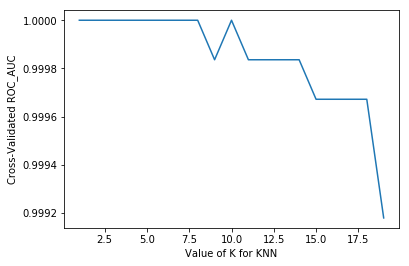

In [20]:
# Choose K between 1 to 20 to analyze score outcomes
k_range = range(1, 20)
k_scores = []

# Use iteration to caclulate different K in models, then return the average accuracy based on the CV
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores_knn = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores_knn.mean())

# Plot
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated ROC_AUC')
plt.show()


## Naive Bayes Model

0.9989793737547223
0.9980389876481605
0.9959199956880038
0.9913986553964144
0.9841212959532453


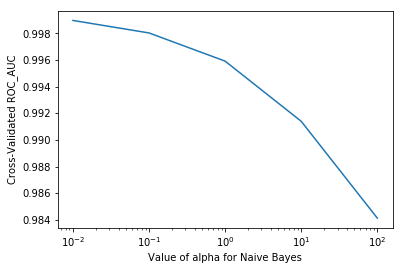

In [21]:
alpha = [0.01, 0.1, 1, 10, 100]
n_scores = []

for a in alpha:
    bnl = BernoulliNB(a)
    scores_nb = cross_val_score(bnl, X_train, y_train, cv=5, scoring='roc_auc')
    n_scores.append(scores_nb.mean())
    print(np.mean(scores_nb))

# Plot
plt.semilogx(alpha, n_scores)
plt.xlabel('Value of alpha for Naive Bayes')
plt.ylabel('Cross-Validated ROC_AUC')
plt.show()


In [22]:
max(n_scores)


0.9989793737547223

## SVM Model

0.9960474838393992
0.9999811234713027
1.0
1.0
1.0


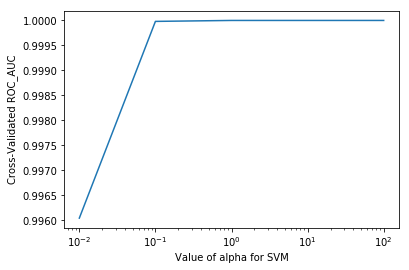

In [23]:
alpha = [0.01, 0.1, 1, 10, 100]
s_scores = []

for a in alpha:
    svm = SVC(gamma='scale', C=a, probability=True)
    scores_svm = cross_val_score(svm, X_train, y_train, cv=5, scoring='roc_auc')
    s_scores.append(scores_svm.mean())
    print(np.mean(scores_svm))

# Plot
plt.semilogx(alpha, s_scores)
plt.xlabel('Value of alpha for SVM')
plt.ylabel('Cross-Validated ROC_AUC')
plt.show()


In [25]:
max(s_scores)


1.0

## Best overall model

In [26]:
# Applying best model
best_model = SVC(gamma='scale', C=1, probability=True)
train = best_model.fit(X_train, np.ravel(y_train))


In [29]:
# Predictions
predictions_test = best_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, predictions_test)


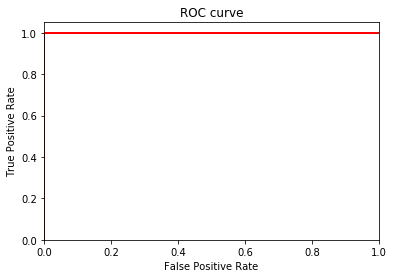

In [30]:
# Plotting
plt.plot(fpr_test, tpr_test, 'r', linewidth=2, markersize=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC curve')
plt.show()
